# Mobile Malware Classification - Multi-View Data Fusion

**Project:** Malware Detection using Hybrid Features (Static + Dynamic)
**Platform:** Apache Spark (PySpark)

This notebook implements a complex pipeline that ingests multiple CSV sources, fuses them into a single feature set, and trains ML models.

### Data Sources:
1. **Static Analysis:** Raw attributes (Intents, Activities) -> Processed via TF-IDF.
2. **Dynamic Syscalls:** System call frequencies -> Processed via VectorAssembler.
3. **Permissions/Binders:** High-level actions (ACCESS_PERSONAL_INFO) -> Processed via VectorAssembler.


## 1. Setup

If you run this in a fresh environment, install deps once (then comment it out).

In [1]:
# !pip install pyspark pandas seaborn matplotlib numpy scikit-learn

## 2. Imports + Spark session

In [2]:
import os
import sys
import re

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, HashingTF, IDF, VectorAssembler, StringIndexer
)
from pyspark.ml.classification import (
    RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, NaiveBayes,
    GBTClassifier, OneVsRest
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make sure PySpark uses the current python
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# NOTE: 'PYSPARK_GATEWAY_SECRET' is usually managed by the environment;
# keep only if you know you need it.
# os.environ['PYSPARK_GATEWAY_SECRET'] = '600'

spark = (SparkSession.builder
    .appName('Malware_MultiSource_Fusion')
    .master('local[*]')
    .config('spark.executor.memory', '10g')
    .config('spark.driver.memory', '10g')
    .config('spark.sql.autoBroadcastJoinThreshold', -1)
    .config('spark.executor.heartbeatInterval', '60s')
    .config('spark.network.timeout', '300s')
    .config('spark.executor.memoryOverhead', '10g')
    .config('spark.python.worker.reuse', 'false')
    .getOrCreate())

print(f'Spark Active. Version: {spark.version}')

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/17 04:47:04 WARN Utils: Your hostname, Dragoss-Laptop.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.128 instead (on interface en0)
26/01/17 04:47:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/17 04:47:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^

Py4JError: An error occurred while calling None.org.apache.spark.sql.classic.SparkSession

## 3. Multi-source ingestion

In [ ]:
# Define file paths (update if needed)
PATH_STATIC = 'static.csv'
PATH_SYSCALLS = 'syscalls.csv'
PATH_PERMS = 'permissions.csv'

print('Reading CSVs...')

# Static: read as raw text to handle strange formatting/encoding
df_static = spark.read.text(PATH_STATIC).withColumnRenamed('value', 'raw_static_text')

# Numeric/structured files
df_syscalls = spark.read.csv(PATH_SYSCALLS, header=True, inferSchema=True)
df_perms = spark.read.csv(PATH_PERMS, header=True, inferSchema=True)

print(f'Static Rows: {df_static.count()}')
print(f'Syscalls Rows: {df_syscalls.count()}')
print(f'Permissions Rows: {df_perms.count()}')

Reading CSVs...
Static Rows: 11599
Syscalls Rows: 11598
Permissions Rows: 8556


## 4. Alignment + fusion (safe joins)

We remove duplicate column names before adding `row_id`, then left-join everything.

In [ ]:
def drop_duplicate_columns(df_left, df_right, df_name: str):
    left_cols = set(df_left.columns)
    right_cols = set(df_right.columns)
    common_cols = left_cols.intersection(right_cols)

    if common_cols:
        print(f'⚠️ Found {len(common_cols)} duplicate columns in {df_name}. Dropping them to avoid ambiguity...')
        for c in common_cols:
            df_right = df_right.drop(c)
    return df_right

# Base = syscalls; drop duplicates in other sources
df_perms_clean = drop_duplicate_columns(df_syscalls, df_perms, 'Permissions DF')
df_static_clean = drop_duplicate_columns(df_syscalls, df_static, 'Static DF')

# Add row index for alignment
def add_index(df):
    return df.withColumn('row_id', F.monotonically_increasing_id())

df_static_i = add_index(df_static_clean)
df_syscalls_i = add_index(df_syscalls)
df_perms_i = add_index(df_perms_clean)

print('Joining DataFrames...')
df_merged = (df_static_i
    .join(df_syscalls_i, 'row_id', 'left')
    .join(df_perms_i, 'row_id', 'left')
    .drop('row_id'))

print('Merged rows:', df_merged.count())
print('Merged cols:', len(df_merged.columns))

⚠️ Found 140 duplicate columns in Permissions DF. Dropping them to avoid ambiguity...
Joining DataFrames...
Merged rows: 11599
Merged cols: 472


## 5. Target column detection + column sanitization + missing values

We (1) detect the label column, (2) sanitize column names, (3) fill nulls.

In [ ]:
# --- target / label column detection ---
possible_labels = ['class', 'Class', 'label', 'Label', 'family', 'type']
target_col = next((c for c in df_merged.columns if c in possible_labels), None)

if target_col is None:
    print("WARNING: Could not find a standard label column. Using the second-to-last column as target.")
    target_col = df_merged.columns[-2]

print(f'Target Column identified: {target_col}')

# --- clean & de-duplicate column names ---
clean_names = []
name_counts = {}

for col_name in df_merged.columns:
    clean = re.sub(r'[^\w]', '', col_name).strip('_')

    if clean in name_counts:
        name_counts[clean] += 1
        unique_name = f'{clean}_{name_counts[clean]}'
    else:
        name_counts[clean] = 0
        unique_name = clean

    clean_names.append(unique_name)

# Keep mapping so we can update target_col after renaming
rename_map = dict(zip(df_merged.columns, clean_names))
df_clean = df_merged.toDF(*clean_names)
target_col_clean = rename_map[target_col]

# Fill missing values: numeric -> 0, strings -> ""
df_clean_filled = df_clean.na.fill(0).na.fill('')
df_clean_filled = df_clean_filled.filter(df_clean_filled["class"] != 0)

print('Row count before fill:', df_clean.count())
print('Row count after fill: ', df_clean_filled.count())

# Quick null check on a small sample of columns
null_counts = df_clean_filled.select([
    _sum(col(c).isNull().cast('int')).alias(c)
    for c in df_clean_filled.columns[:5]
])
null_counts.show()

# Create a text column for NLP pipeline (fallbacks to first column if missing)
if 'raw_static_text' in df_clean_filled.columns:
    df_clean_filled = df_clean_filled.withColumn('text_clean', col('raw_static_text'))
elif 'rawstatictext' in df_clean_filled.columns:
    df_clean_filled = df_clean_filled.withColumn('text_clean', col('rawstatictext'))
else:
    df_clean_filled = df_clean_filled.withColumn('text_clean', col(df_clean_filled.columns[0]).cast('string'))

print('Using label column:', target_col_clean)
print('Using text column: text_clean')

Target Column identified: Class
Row count before fill: 11599
Row count after fill:  5811
+---------------+-----------------+--------------+------+---------+
|raw_static_text|arm_nr_cacheflush|arm_nr_set_tls|llseek|newselect|
+---------------+-----------------+--------------+------+---------+
|              0|                0|             0|     0|        0|
+---------------+-----------------+--------------+------+---------+

Using label column: Class
Using text column: text_clean


## 6. Feature column discovery (numeric)

In [ ]:
exclude_cols = {
    'label', 'id', 'features', 'text_raw', 'text_clean',
    'words', 'raw_features', 'tfidf_features', target_col_clean
}

numeric_cols = [
    field.name for field in df_clean_filled.schema.fields
    if field.dataType.simpleString() in ['int', 'double', 'float', 'long']
    and field.name not in exclude_cols
]

print(f'Identified {len(numeric_cols)} numeric features.')
print('Example numeric cols:', numeric_cols[:10])

Identified 470 numeric features.
Example numeric cols: ['arm_nr_cacheflush', 'arm_nr_set_tls', 'llseek', 'newselect', 'accept', 'access', 'bind', 'brk', 'capset', 'chdir']


## 7. EDA (optional)

--- Starting EDA ---


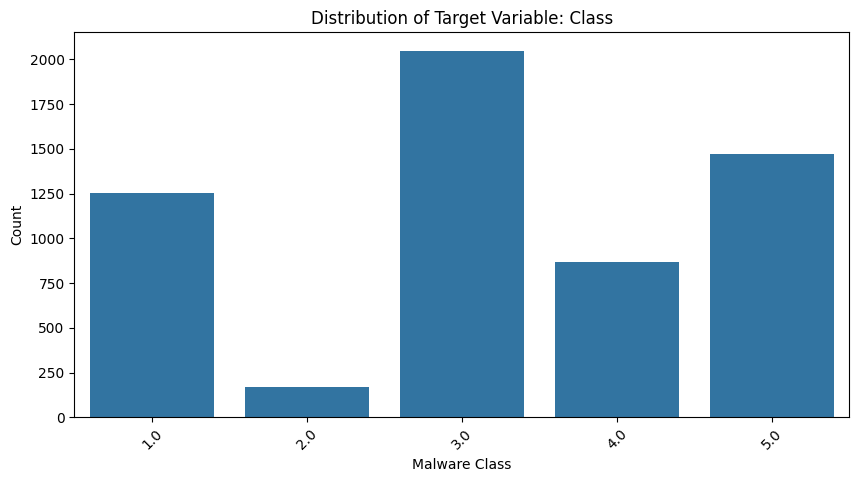

Generating Correlation Matrix for top numeric features...


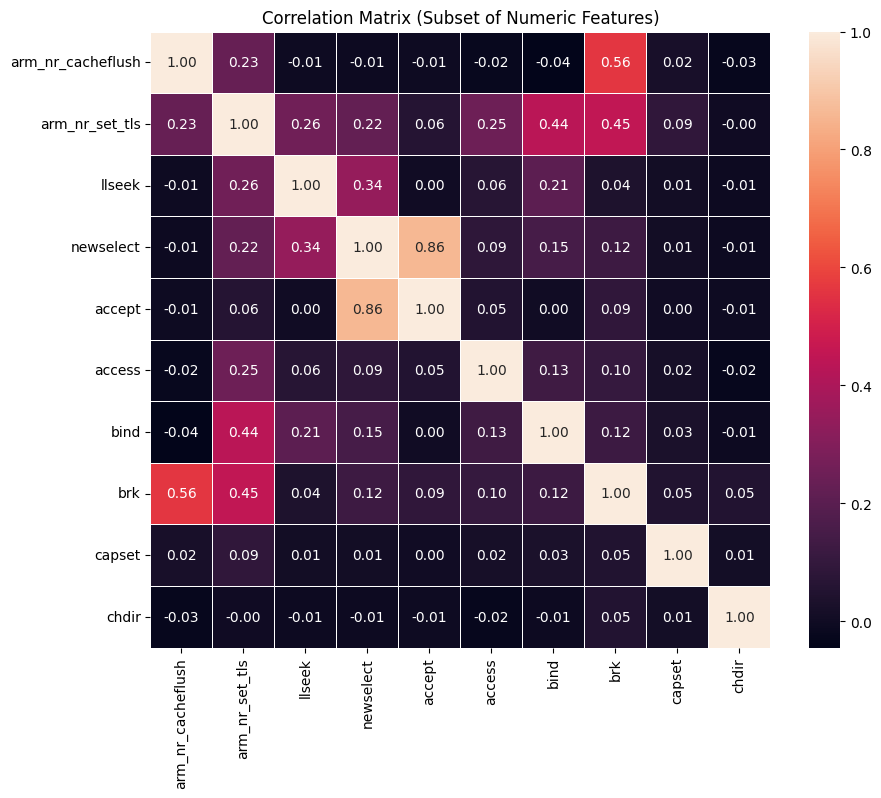

--- EDA Complete ---


In [ ]:
print('--- Starting EDA ---')

# Class balance
class_counts = (df_clean_filled
    .groupBy(target_col_clean)
    .count()
    .orderBy('count', ascending=False)
    .toPandas())

plt.figure(figsize=(10, 5))
sns.barplot(x=target_col_clean, y='count', data=class_counts)
plt.title(f'Distribution of Target Variable: {target_col_clean}')
plt.ylabel('Count')
plt.xlabel('Malware Class')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for a small numeric subset
print('Generating Correlation Matrix for top numeric features...')
num_subset = numeric_cols[:10]

if not num_subset:
    print('No numeric features found for correlation plot.')
else:
    # sample to reduce driver memory usage
    sample_pdf = (df_clean_filled
        .select(num_subset)
        .sample(fraction=0.1, seed=42)
        .toPandas())

    plt.figure(figsize=(10, 8))
    corr = sample_pdf.corr(numeric_only=True)
    sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix (Subset of Numeric Features)')
    plt.show()

print('--- EDA Complete ---')

## 8. Feature engineering pipeline (TF-IDF + numeric fusion)

In [ ]:
# Text processing
tokenizer = Tokenizer(inputCol='text_clean', outputCol='words')
hashingTF = HashingTF(inputCol='words', outputCol='raw_features', numFeatures=1000)
idf = IDF(inputCol='raw_features', outputCol='tfidf_features')

# Numeric assembler
assembler_numeric = VectorAssembler(
    inputCols=numeric_cols,
    outputCol='numeric_features',
    handleInvalid='keep'
)

# Final fusion assembler
assembler_final = VectorAssembler(
    inputCols=['tfidf_features', 'numeric_features'],
    outputCol='features',
    handleInvalid='skip'
)

# Label indexer
label_indexer = StringIndexer(
    inputCol=target_col_clean,
    outputCol='label',
    handleInvalid='skip'
)

pipeline = Pipeline(stages=[
    tokenizer, hashingTF, idf,
    assembler_numeric, assembler_final,
    label_indexer
])

print('Running feature pipeline...')
model_prep = pipeline.fit(df_clean_filled)
final_data = model_prep.transform(df_clean_filled).select('features', 'label')

final_data.show(5)
print('✅ Pipeline complete.')

Running feature pipeline...


26/01/17 04:45:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[215.096636020315...|  2.0|
|(1470,[698,1001,1...|  2.0|
|(1470,[656,1001,1...|  2.0|
|(1470,[568,1000,1...|  2.0|
|(1470,[672,1001,1...|  2.0|
+--------------------+-----+
only showing top 5 rows
✅ Pipeline complete.


## 9. Train/test split + baseline models

In [ ]:
print('Splitting data into Train (70%) and Test (30%)...')
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

# Cache to avoid recomputation across many models
train_data.cache()
test_data.cache()
print(f'Train rows: {train_data.count()}')
print(f'Test rows:  {test_data.count()}')

# Train models
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=20)
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10)
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
nb = NaiveBayes(labelCol='label', featuresCol='features', modelType='multinomial')

print('Training Random Forest...')
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

print('Training Logistic Regression...')
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)

print('Training Decision Tree...')
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(test_data)

print('Training Naive Bayes...')
nb_model = nb.fit(train_data)
nb_preds = nb_model.transform(test_data)

print('✅ Baseline models trained.')

Splitting data into Train (70%) and Test (30%)...


NameError: name 'final_data' is not defined

## 10. Advanced model (GBT via OneVsRest) + evaluation

In [ ]:
# Evaluators
f1_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
acc_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

def evaluate_model(predictions, model_name: str):
    acc = acc_eval.evaluate(predictions)
    f1 = f1_eval.evaluate(predictions)
    print(f'Results for {model_name}:')
    print(f'  Accuracy: {acc:.4f}')
    print(f'  F1-Score: {f1:.4f}')
    print('-' * 30)
    return acc, f1

print('Training Gradient Boosted Trees (GBT) with OneVsRest...')
# Light params to reduce timeouts
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=1, checkpointInterval=2)
ovr_gbt = OneVsRest(classifier=gbt, labelCol='label', featuresCol='features')

train_ckpt = train_data.localCheckpoint()
gbt_model = ovr_gbt.fit(train_ckpt)
gbt_preds = gbt_model.transform(test_data)

# Collect scores
acc_gbt, f1_gbt = evaluate_model(gbt_preds, 'Gradient Boosting (OneVsRest)')
acc_rf, f1_rf = evaluate_model(rf_preds, 'Random Forest')
acc_lr, f1_lr = evaluate_model(lr_preds, 'Logistic Regression')
acc_dt, f1_dt = evaluate_model(dt_preds, 'Decision Tree')
acc_nb, f1_nb = evaluate_model(nb_preds, 'Naive Bayes')

# Build visualization dataframe
data = {
    'Model': [
        'Random Forest', 'Random Forest',
        'Logistic Reg', 'Logistic Reg',
        'Decision Tree', 'Decision Tree',
        'Naive Bayes', 'Naive Bayes',
        'Gradient Boosting', 'Gradient Boosting'
    ],
    'Metric': [
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score'
    ],
    'Score': [
        acc_rf, f1_rf,
        acc_lr, f1_lr,
        acc_dt, f1_dt,
        acc_nb, f1_nb,
        acc_gbt, f1_gbt
    ]
}

print('✅ Evaluation complete.')

Training Gradient Boosted Trees (GBT) with OneVsRest...


Results for Gradient Boosting (OneVsRest):
  Accuracy: 0.8900
  F1-Score: 0.8907
------------------------------


Results for Random Forest:
  Accuracy: 0.8465
  F1-Score: 0.8319
------------------------------


Results for Logistic Regression:
  Accuracy: 0.8544
  F1-Score: 0.8534
------------------------------
Results for Decision Tree:
  Accuracy: 0.8736
  F1-Score: 0.8729
------------------------------
Results for Naive Bayes:
  Accuracy: 0.4757
  F1-Score: 0.4548
------------------------------
✅ Evaluation complete.


## 11. Visual comparison + detailed report

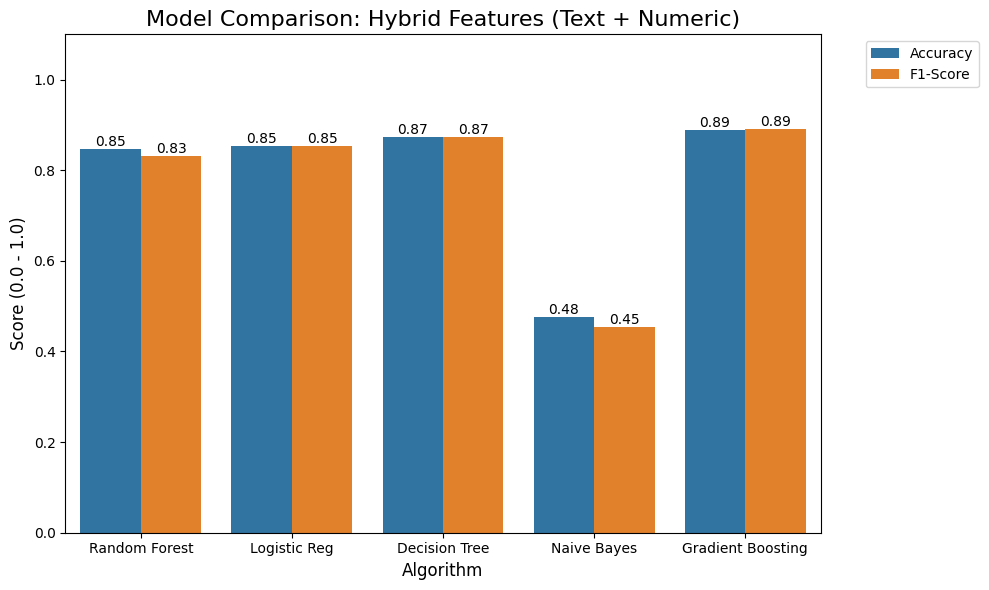

In [ ]:
df_viz = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plot = sns.barplot(x='Model', y='Score', hue='Metric', data=df_viz)

plt.title('Model Comparison: Hybrid Features (Text + Numeric)', fontsize=16)
plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for container in plot.containers:
    plot.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

# Detailed metrics + confusion matrix
def print_detailed_metrics(predictions, model_name: str):
    print(f'\n--- Detailed Report: {model_name} ---')

    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})

    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall:    {recall:.4f}')

    # Collect for confusion matrix (sample if huge)
    y_true = predictions.select('label').rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Run for best model (adjust as needed)
#print_detailed_metrics(gbt_preds, 'Gradient Boosting')
# print_detailed_metrics(rf_preds, 'Random Forest')

### Robust evaluation (confusion matrix + per-class metrics + AUC for binary)

This cell evaluates a predictions DataFrame (`*_preds`) produced by Spark ML models (columns: `label`, `prediction`, and usually `probability`).



===== Graph evaluation: Random Forest =====


/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.846501
Weighted Precision: 0.824381
Weighted Recall:    0.846501
Weighted F1:        0.831942


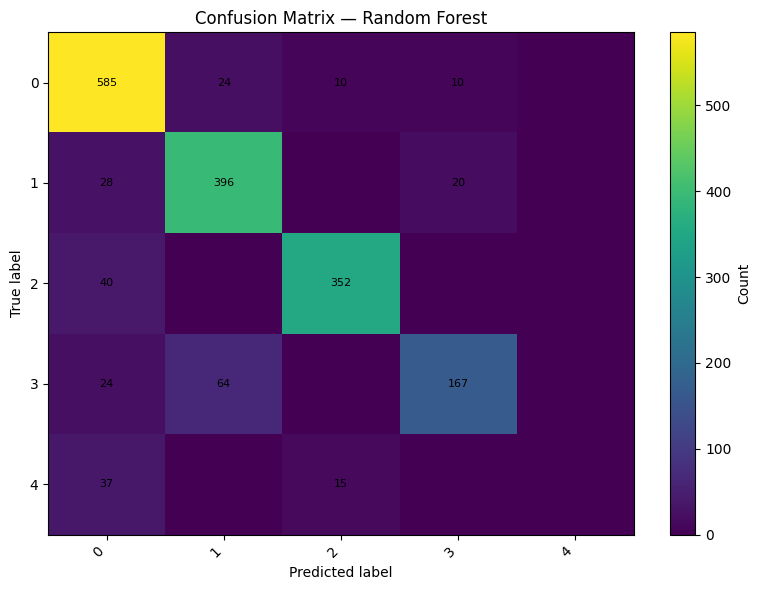

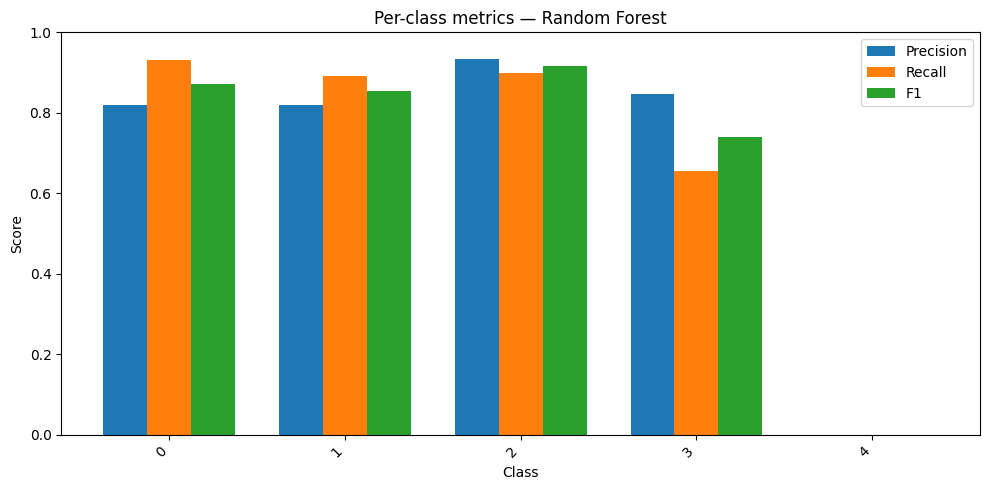


===== Graph evaluation: Logistic Regression =====


/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.854402
Weighted Precision: 0.854744
Weighted Recall:    0.854402
Weighted F1:        0.853414


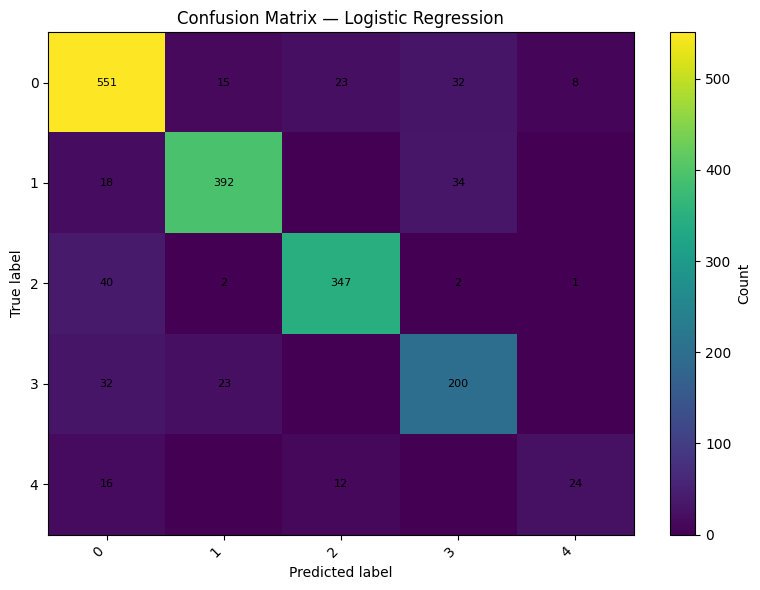

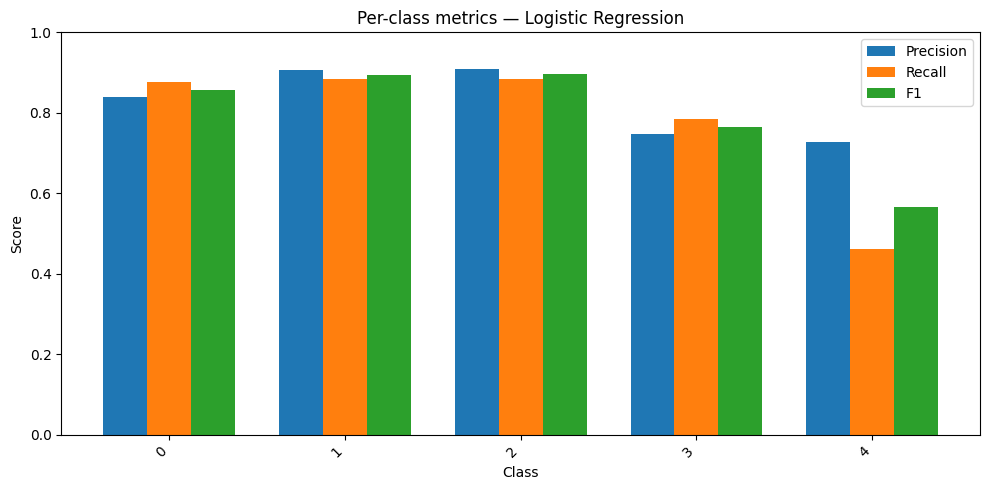


===== Graph evaluation: Decision Tree =====


/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.873589
Weighted Precision: 0.874263
Weighted Recall:    0.873589
Weighted F1:        0.872869


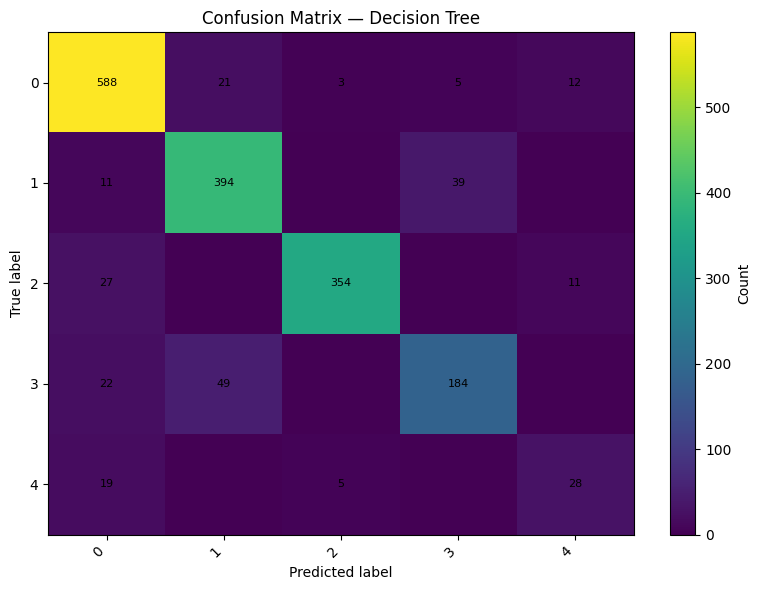

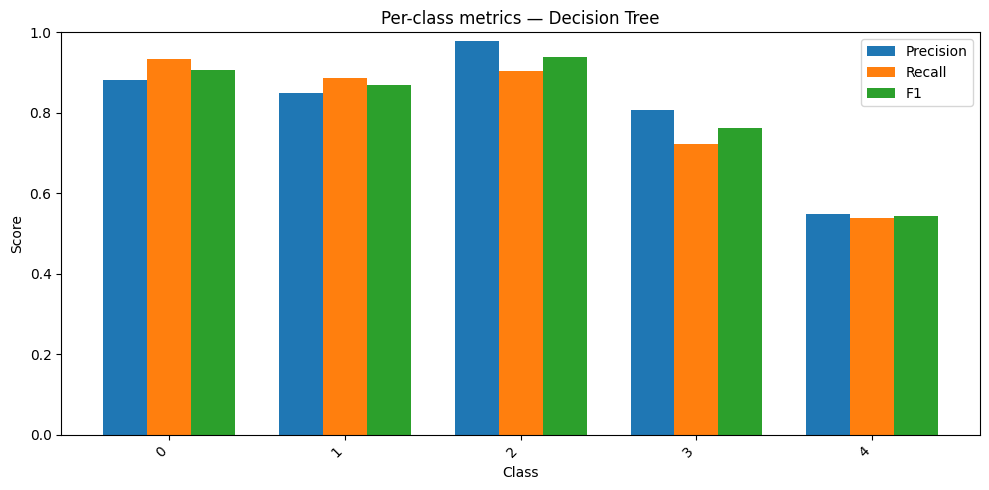


===== Graph evaluation: Naive Bayes =====


/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.475734
Weighted Precision: 0.529529
Weighted Recall:    0.475734
Weighted F1:        0.454751


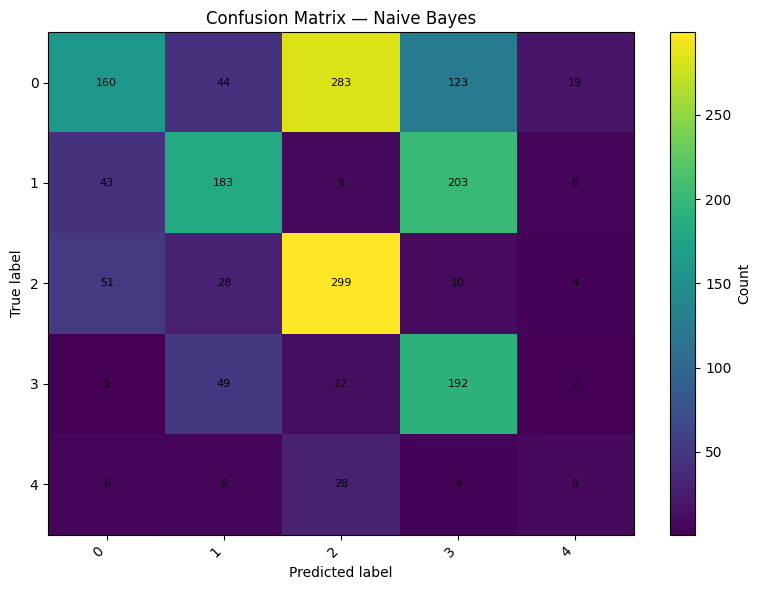

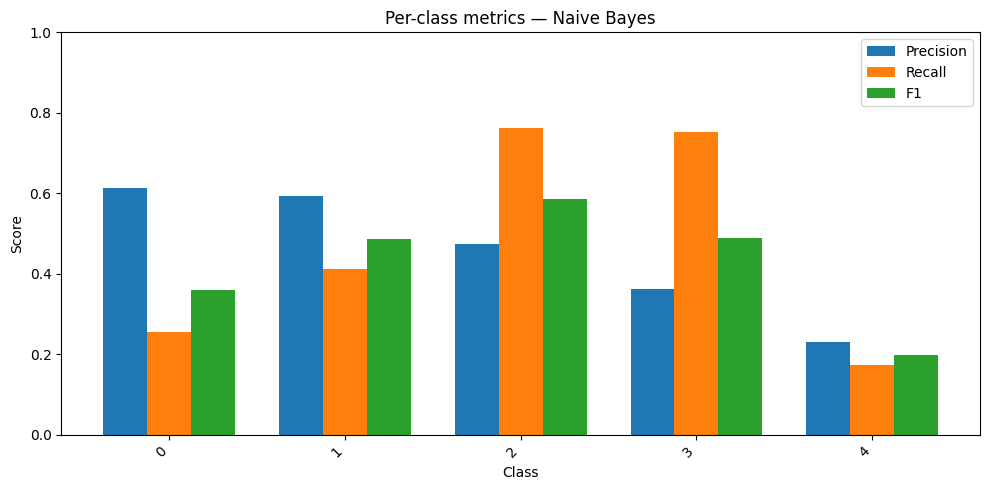


===== Graph evaluation: Gradient Boosting (OneVsRest) =====


/Users/dragos/Uni/Introduction to Big Data/project/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.889955
Weighted Precision: 0.892139
Weighted Recall:    0.889955
Weighted F1:        0.890662


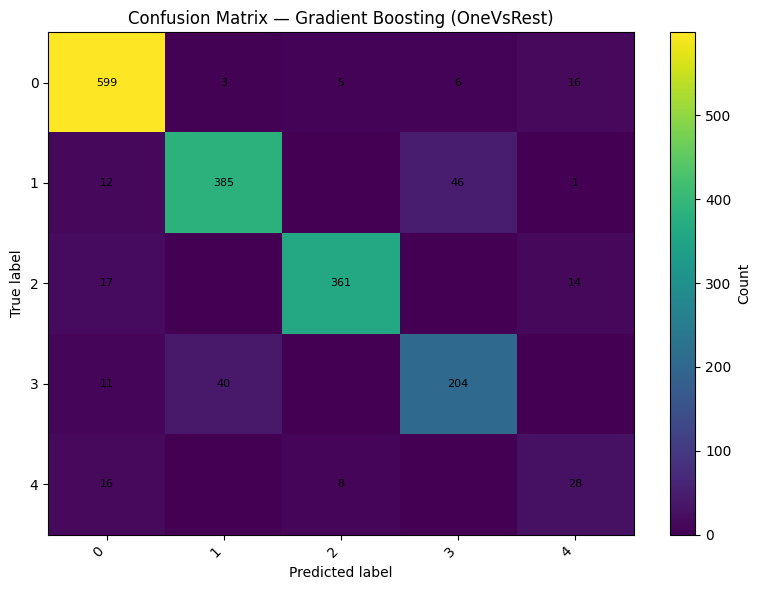

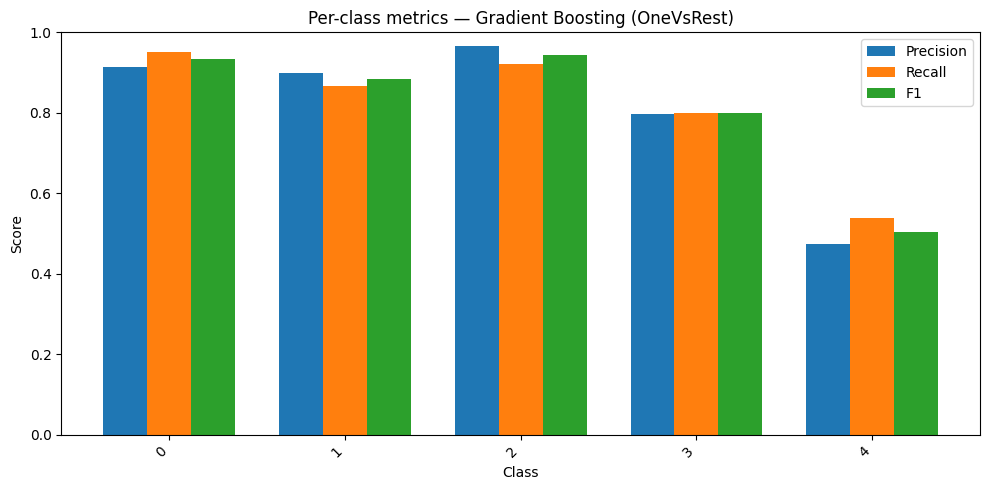

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.mllib.evaluation import MulticlassMetrics

import numpy as np
import matplotlib.pyplot as plt

# Make sure Spark is alive (prevents SparkContext assertion errors)
spark = SparkSession.builder.getOrCreate()

# -----------------------------
# Configure columns
# -----------------------------
label_col = "label"       # change to "class" if needed
pred_col  = "prediction"  # Spark ML default

# -----------------------------
# Models to evaluate (edit names/vars if yours differ)
# -----------------------------
models = [
    (rf_preds,  "Random Forest"),
    (lr_preds,  "Logistic Regression"),
    (dt_preds,  "Decision Tree"),
    (nb_preds,  "Naive Bayes"),
    (gbt_preds, "Gradient Boosting (OneVsRest)"),
]

for preds, model_name in models:
    print(f"\n===== Graph evaluation: {model_name} =====")

    # -----------------------------
    # Build confusion matrix counts
    # -----------------------------
    cm_counts = (
        preds
        .select(F.col(label_col).cast("int").alias("label"),
                F.col(pred_col).cast("int").alias("prediction"))
        .groupBy("label", "prediction")
        .count()
    )

    labels = [r["label"] for r in cm_counts.select("label").distinct().orderBy("label").collect()]
    pred_labels = [r["prediction"] for r in cm_counts.select("prediction").distinct().orderBy("prediction").collect()]
    all_classes = sorted(set(labels) | set(pred_labels))

    # Create dense confusion matrix in driver (size = #classes x #classes)
    cm_dict = {(r["label"], r["prediction"]): r["count"] for r in cm_counts.collect()}
    cm = np.zeros((len(all_classes), len(all_classes)), dtype=np.int64)

    idx = {c: i for i, c in enumerate(all_classes)}
    for (y, yhat), cnt in cm_dict.items():
        cm[idx[y], idx[yhat]] = cnt

    # -----------------------------
    # Multiclass metrics
    # -----------------------------
    metrics_rdd = (
        preds
        .select(F.col(pred_col).cast("double"), F.col(label_col).cast("double"))
        .rdd
        .map(lambda r: (float(r[0]), float(r[1])))  # (prediction, label)
    )
    mc = MulticlassMetrics(metrics_rdd)

    precisions = [mc.precision(float(c)) for c in all_classes]
    recalls    = [mc.recall(float(c)) for c in all_classes]
    f1s        = [mc.fMeasure(float(c)) for c in all_classes]

    print(f"Accuracy: {mc.accuracy:.6f}")
    print(f"Weighted Precision: {mc.weightedPrecision:.6f}")
    print(f"Weighted Recall:    {mc.weightedRecall:.6f}")
    print(f"Weighted F1:        {mc.weightedFMeasure():.6f}")

    # -----------------------------
    # Plot 1: Confusion matrix heatmap
    # -----------------------------
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, aspect="auto")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks(range(len(all_classes)), all_classes, rotation=45, ha="right")
    plt.yticks(range(len(all_classes)), all_classes)

    # annotate cells (skip zeros to reduce clutter)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            if v != 0:
                plt.text(j, i, str(v), ha="center", va="center", fontsize=8)

    plt.colorbar(label="Count")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot 2: Per-class metric bars
    # -----------------------------
    x = np.arange(len(all_classes))
    width = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, precisions, width, label="Precision")
    plt.bar(x,         recalls,    width, label="Recall")
    plt.bar(x + width, f1s,        width, label="F1")
    plt.title(f"Per-class metrics — {model_name}")
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.xticks(x, all_classes, rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
from pyspark.ml import PipelineModel

MODEL_PATH = "models/maldroid_hybrid_best_pipeline"

# overwrite if it exists
gbt_model.write().overwrite().save(MODEL_PATH)

print("Saved pipeline model to:", MODEL_PATH)

Saved pipeline model to: models/maldroid_hybrid_best_pipeline


## 12. Cleanup

In [ ]:
spark.stop()
print('Spark stopped.')

Spark stopped.


In [2]:
# =========================
# 13. Demo / Inference (More synthetic data)
# =========================
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import PipelineModel
import random

spark = SparkSession.builder.getOrCreate()

MODEL_PATH = "models/maldroid_hybrid_best_pipeline"
full_model = PipelineModel.load(MODEL_PATH)

tokenizer = full_model.stages[0]
assembler_numeric = full_model.stages[3]

text_col = tokenizer.getInputCol()
numeric_cols = assembler_numeric.getInputCols()

infer_stages = [full_model.stages[i] for i in [0,1,2,3,4,6]]
infer_model = PipelineModel(stages=infer_stages)

label_map = {
    0: 'Benign',
    1: 'Adware',
    2: 'Banking',
    3: 'SMS Malware',
    4: 'Riskware'
}

label_map_bc = spark.sparkContext.broadcast(label_map)

@F.udf("string")
def pred_to_name(p):
    return label_map_bc.value.get(int(p), "Unknown") if p is not None else "Unknown"


# --- Fake text pool ---
fake_texts = [
    "open camera take photo save to storage",
    "access contacts send email notification",
    "read calendar set reminder",
    "play music access audio stream",
    "use gps get location show map",

    "display popup ads access network",
    "download ad content show banner",
    "track user behavior send analytics",
    "redirect browser to ad website",
    "inject ads into app interface",

    "read sms intercept otp send to server",
    "access phone state steal credentials",
    "record keystrokes capture password",
    "overlay fake login screen",
    "exfiltrate banking data",

    "send premium sms without user consent",
    "intercept incoming messages",
    "hide sms notifications",
    "auto reply to messages",
    "subscribe user to paid services",

    "download apk from unknown source",
    "execute shell commands",
    "access root privileges",
    "modify system settings",
    "install additional packages"
]


def generate_numeric_features(text, numeric_cols):
    row = {}
    text = text.lower()

    for c in numeric_cols:
        val = 0.0
        if "sms" in text and "SMS" in c:
            val = 1.0
        elif "network" in text and "NETWORK" in c:
            val = 1.0
        elif "camera" in text and "camera" in c.lower():
            val = 1.0
        elif "root" in text and "EXECUTE" in c:
            val = 1.0
        elif "file" in text and "FS_" in c:
            val = 1.0
        elif random.random() < 0.05:
            val = 1.0
        row[c] = val

    return row


# --- Generate 20 synthetic samples ---
rows = []
for i in range(20):
    text = random.choice(fake_texts)
    row = {"sample_id": i+1, text_col: text}
    row.update(generate_numeric_features(text, numeric_cols))
    rows.append(row)

demo_df = spark.createDataFrame(rows)

# --- Run inference ---
preds = infer_model.transform(demo_df)
preds = preds.withColumn("Predicted Class", pred_to_name(F.col("prediction")))

if "probability" in preds.columns:
    preds = preds.withColumn("Confidence", F.array_max(F.col("probability")))
    preds.select("sample_id", text_col, "Predicted Class", "Confidence").show(truncate=False)
else:
    preds.select("sample_id", text_col, "Predicted Class").show(truncate=False)

26/01/17 05:18:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/17 05:18:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+---------+---------------------------------------+---------------+
|sample_id|text_clean                             |Predicted Class|
+---------+---------------------------------------+---------------+
|1        |access contacts send email notification|SMS Malware    |
|2        |access phone state steal credentials   |SMS Malware    |
|3        |auto reply to messages                 |SMS Malware    |
|4        |modify system settings                 |SMS Malware    |
|5        |inject ads into app interface          |SMS Malware    |
|6        |display popup ads access network       |SMS Malware    |
|7        |read calendar set reminder             |SMS Malware    |
|8        |access contacts send email notification|SMS Malware    |
|9        |track user behavior send analytics     |SMS Malware    |
|10       |display popup ads access network       |SMS Malware    |
|11       |access contacts send email notification|Benign         |
|12       |access contacts send email notificati